# 1. Install and Imports

Installing and importing our requirements for the model.

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import imageio #render post processed output a lot better (better while working w/ videos)
from typing import List #List type annotations

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
#prevents machine from sucking up all memory and get out of memory errors
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0],True)
except:
  pass

# 2. Functions

These functions help the model load data into its testing and training samples and use the videos and Alignment to understand the information per frames.

In [6]:
def load_video(path: str) -> tf.Tensor:
    # Create OpenCV video capture instance
    cap = cv2.VideoCapture(path)
    frames = []
    
    # Loop through each frame and store the extracted frames in an array
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        if not ret:
            break  # End of video or error
        
        # Convert frame to tensor (from NumPy array)
        frame = tf.convert_to_tensor(frame, dtype=tf.float32)
        
        # Convert RGB to grayscale
        frame = tf.image.rgb_to_grayscale(frame)
        
        # Cropping to the lip region (static slicing)
        cropped_frame = frame[190:236,80:220,:]
        
        # Append the cropped frame to the list
        frames.append(cropped_frame)
    
    # Release video capture object
    cap.release()
    
    # Stack frames into a single tensor
    frames_tensor = tf.stack(frames)

    # Normalize the tensor by mean and std
    mean = tf.math.reduce_mean(frames_tensor)
    std = tf.math.reduce_std(frames_tensor)
    
    # Avoid division by zero in case std is zero
    std = tf.maximum(std, 1e-8)
    
    # Return normalized frames
    return tf.cast((frames_tensor - mean), tf.float32) / std


In [7]:
#creating vocab- every single character that is expected to be encountered in our annotations
vocab= [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [8]:
#originally from the keras ctc Automatic Speech Recognition tutorial paper
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="") #converts char to num
num_to_char = tf.keras.layers.StringLookup(
    vocabulary= char_to_num.get_vocabulary(), oov_token="", invert=True) #converts num to char


print(
    f"the vocabulary is : {char_to_num.get_vocabulary()}\n"
    f"size is : {char_to_num.vocabulary_size()}"
)

the vocabulary is : ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']
size is : 40


In [9]:
#load up our alignments
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]


In [10]:
#returning the preprocessed videos and preprocessed alignments together from their respective paths

def load_data(path:str):
  path = bytes.decode(path.numpy())
  #filename = path.split('/')[-1].split('.')[0] #colab
  filename = path.split('\\')[-1].split('.')[0]
  #for windows.
  video_path = os.path.join('data','s1',f'{filename}.mpg')
  alignment_path = os.path.join('data','alignments','s1',f'{filename}.align')
  frames=load_video(video_path)
  alignments = load_alignments(alignment_path)

  return frames, alignments

# 3. Checking data and Lip viusalization

We see that the data has been properly comprehended by the functions and see how the lips are seen by the model.

In [11]:
test_path = '\\data\\s1\\bbal6n.mpg'

In [12]:
#filename
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [13]:
frames,alignments = load_data(tf.convert_to_tensor(test_path))

In [14]:
mean = tf.math.reduce_mean(frames, axis=[0, 1, 2], keepdims=True)
std = tf.math.reduce_std(tf.cast(frames, tf.float32), axis=[0, 1, 2], keepdims=True)
frames = tf.cast(frames, tf.float32)
normalized_frames = (frames - mean) / std

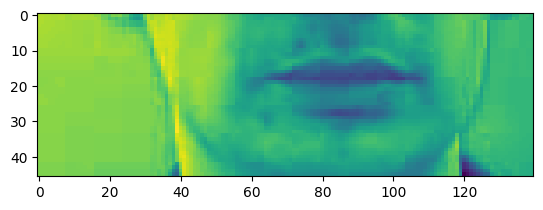

In [15]:
plt.imshow(frames[0])

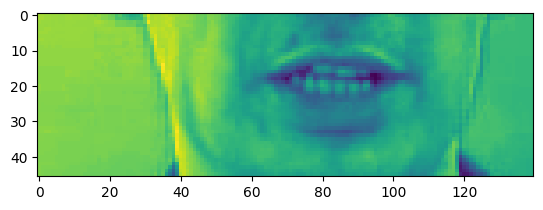

In [16]:
plt.imshow(frames[40])

In [17]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [18]:
tf.strings.reduce_join([num_to_char(word) for word in alignments])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [19]:
def mappable_function(path:str)->List[str]:
  result=tf.py_function(load_data, [path], (tf.float32,tf.int64))
  return result

# 4. Creating Data Pipeline:

Creating our data pipeline:

1. using tensorflow data pipeline we iterate thrugh our videos path.
2. shuffle to get a random video path everytime
3. map the video to its alignments
4. add padding to the alignments (length=40) and take 75 frames for each video (we dont pad each frame/image). Take 2 sets of videos & alignments in one batch.
5. prefetching in order to optimize our pipileine to ensure we are loading and preloading while our model is training.


In [20]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500,reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
#Added for split
train= data.take(450)
test= data.skip(450)

In [21]:
len(train)

450

In [22]:
len(test)

50

In [23]:
#testing each code line in data pipeline:
frames,aligns = data.as_numpy_iterator().next()

In [24]:
len(frames) #2 set of frmes in each batch.

2

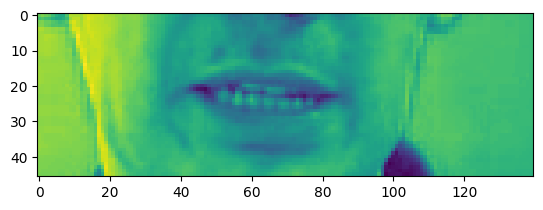

In [25]:
plt.imshow(frames[0][29]) #29th frame of first video

In [26]:
aligns[0] #first video alignment with padding.

array([19,  5, 20, 39,  2, 12, 21,  5, 39,  9, 14, 39, 13, 39,  5,  9,  7,
        8, 20, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0], dtype=int64)

In [27]:
test1= data.as_numpy_iterator()

In [28]:
val= test1.next(); val[0]

array([[[[[ 1.51554763e+00],
          [ 1.51554763e+00],
          [ 1.49100471e+00],
          ...,
          [ 1.60709709e-01],
          [ 1.00876845e-01],
          [ 1.00876845e-01]],

         [[ 1.51554763e+00],
          [ 1.51554763e+00],
          [ 1.49100471e+00],
          ...,
          [ 1.60709709e-01],
          [ 1.00876845e-01],
          [ 1.00876845e-01]],

         [[ 1.43490148e+00],
          [ 1.43490148e+00],
          [ 1.43490148e+00],
          ...,
          [ 6.05534315e-02],
          [ 6.05534315e-02],
          [ 6.05534315e-02]],

         ...,

         [[ 1.07018709e+00],
          [ 1.02986431e+00],
          [ 1.02986431e+00],
          ...,
          [-2.14069784e-01],
          [-2.14069784e-01],
          [-2.14069784e-01]],

         [[ 1.02986431e+00],
          [ 1.02986431e+00],
          [ 1.02986431e+00],
          ...,
          [-2.54393190e-01],
          [-2.54393190e-01],
          [-2.54393190e-01]],

         [[ 1.02986431e+00],
 

In [36]:

fv = (val[0][1].astype(np.uint8) * 255).squeeze()

imageio.mimsave('./animation.gif', fv, duration=100)

The gif created is what the model trains on along with the alignemnts to perform lip reading.

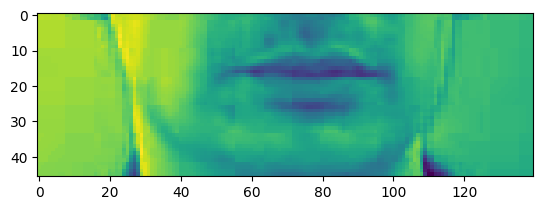

In [37]:
# 0/1: videos/alignments, 0/1: first or second video, 0-74: frames of video 1.
plt.imshow(val[0][0][0])

In [38]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin white by g eight now'>

# 5. Model Initialization

This shows us the different tensorflow and machine learning functions we use to train the model and the number of hyper parameters involved

In [39]:
from keras.models import Sequential
from keras.layers import Dense,Conv3D,LSTM, Dropout,Bidirectional, Activation, SpatialDropout3D, BatchNormalization, MaxPool3D,Reshape, Flatten,TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [40]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [41]:
char_to_num.vocabulary_size()

40

In [34]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [36]:
yhat = model.predict(val[0])

1/1 [==============================] - 2s 2s/step


In [37]:
yhat[0].shape

(75, 41)

In [38]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lll??????????????????????????????????????????????????????????????????444444'>

In [39]:
model.input_shape

(None, 75, 46, 140, 1)

In [40]:
model.output_shape

(None, 75, 41)

# 6. Setting Up Model Training

In [41]:
def scheduler(epoch,lr):
  if epoch<30:
    return lr
  else:
    return lr*tf.math.exp(-0.1)

In [42]:
#CTC LOSS - this block of code has been picked up from Automatic Speech Recognition using CTC paper.
def CTCLoss(y_true,y_pred):
  batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
  input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
  label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

  input_length=input_length* tf.ones(shape=(batch_len,1),dtype='int64')
  label_length = label_length* tf.ones(shape=(batch_len,1), dtype='int64')

  loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
  return loss


In [43]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [44]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),loss =CTCLoss)

In [45]:
checkpoint_callback= ModelCheckpoint(os.path.join('models','checkpoint.h5'),monitor='loss', save_weights_only=True, save_best_only=True)


In [46]:
schedule_callback = LearningRateScheduler(scheduler)

In [47]:
example_callback = ProduceExample(data)

In [ ]:
model.fit(train, validation_data=test, epochs=50, callbacks=[checkpoint_callback, schedule_callback, example_callback], )

We can take note how by 50 epochs the model starts recognising and predicting comparble sentences.

# 7. Calculating Metrics

Loading in the checkpoint weights to calculate the metrics and train the model

In [49]:
model.load_weights('models/checkpoint')

In [51]:
# Initialize variables to track performance
total_words = 0
total_errors = 0

# Loop over each video in the test dataset
for sample in test:
    # Predict using the model
    yhat = model.predict(sample[0])

    ground_truth = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]
    decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()
    predictions = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

    for i in range(len(predictions)):
        # Split predictions and ground truth into words
        prediction_words = predictions[i].numpy().split()
        ground_truth_words = ground_truth[i].numpy().split()

        # Calculate Levenshtein distance (edit distance) between predictions and ground truth
        errors = np.sum(prediction_words != ground_truth_words)
        total_errors += errors
        total_words += len(ground_truth_words)

# Calculate Word Error Rate
wer = (total_errors / total_words) * 100
print(f"Word Error Rate on Test Dataset: {wer:.2f}%")



1/1 [==============================] - 0s 97ms/step
Word Error Rate on Test Dataset: 16.67%


In [ ]:
total_samples = 0
correct_predictions = 0
# Looping over each vid
for sample in test.take(50):
    # Prediction using Lipsin model
    yhat = model.predict(sample[0])

    ground_truth = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]
    decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()
    predictions = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

    for i in range(len(predictions)):
        total_samples += 1
        prediction = predictions[i].numpy()
        gt = ground_truth[i].numpy()
        if prediction == gt:
            correct_predictions += 1

# Calculate accuracy percentage
accuracy_percentage = (correct_predictions / total_samples) * 100
print(f"Accuracy: {accuracy_percentage:.2f}%")


# 8. Testing on Random unseen videos

loading a random video as a sample

In [50]:
sample = test.as_numpy_iterator().next()

In [51]:
yhat = model.predict(sample[0])

1/1 [==============================] - 1s 1s/step


In [57]:
print('~'*20, 'REAL TEXT','~'*20)
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~ REAL TEXT ~~~~~~~~~~~~~~~~~~~~


[<tf.Tensor: shape=(), dtype=string, numpy=b'place red at p four now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set white by i five soon'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()
print('~'*20, 'PREDICTIONS','~'*20)
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]


Our predictions seem to be near perfect.

# END